In [2]:
#Se importan librerías que se van a usar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Se convierten a df los archivos con lo que se va a trabajar
colombiaTrain = pd.read_csv('properties_colombia_train.csv')
colombiaTest = pd.read_csv('properties_colombia_test.csv')

In [4]:
#Se crea la variable target
colombiaTrain['clasificacion']=np.where(colombiaTrain.price>=colombiaTrain.price.mean(), 1, 0)

In [5]:
#Se borran las filas que tienen no tienen valor o tienen valor 0 en la columna price,
#ya que quedan como apartamentos baratos pero en realidad no lo sabemos 
#y puede complicar el resultado de predicción

colombiaTrain.drop(colombiaTrain[colombiaTrain.price == 0].index,inplace=True)
colombiaTrain.drop(colombiaTrain[colombiaTrain.price.isnull()==True].index,inplace=True)

In [6]:
#Se borran las filas con moneda expresadas en USD, 
#a que la mayoría de los datos están expresado en COP, 
#y se puede llegar a entender que son baratas y puede que no sea así.
#Además la cantidad es menor la 1% con respecto a todo el dataset
colombiaTrain.drop(colombiaTrain[colombiaTrain.currency == 'USD'].index, inplace=True)



In [703]:
#Se encuentran segun sus coordenadas que hay filas que están fuera de Colombia
#Si bien las coordenadas están mal, todos los demás datos circunscriben a Colombia
#Por lo que se decide a dejarlos en el df
print(colombiaTrain[colombiaTrain.lat==colombiaTrain.lat.max()])
colombiaTrain[colombiaTrain.lat==colombiaTrain.lat.min()]

        Unnamed: 0                        id    ad_type  start_date  \
148562      819292  s6bCv2RXRdHQGyS2+7WZ8Q==  Propiedad  2020-11-06   

          end_date  created_on        lat        lon        l1            l2  \
148562  2021-07-26  2020-11-06  34.420334 -119.69819  Colombia  Cundinamarca   

        ... surface_covered        price currency price_period  \
148562  ...             NaN  600000000.0      COP          NaN   

                                           title  \
148562  51599  SANTA  BARBARA  APARTAMENTO  506    

                                              description  property_type  \
148562  Apartamento&nbsp; para&nbsp; remodelar , duple...    Apartamento   

        operation_type                      geometry  clasificacion  
148562           Venta  POINT (-119.69819 34.420334)              0  

[1 rows x 28 columns]


,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry,clasificacion
138682,172722,0xtrMhsbAsQiEv9XHGWTIQ==,Propiedad,2020-09-29,2021-07-26,2020-09-29,-32.787342,-71.20732,Colombia,Cundinamarca,...,NaN,2.000000e+09,COP,NaN,51548 LA CALERA MIRADO DEL LAGO,"Casa hermosa,amplia, vigilancia sector&nbsp; t...",Casa,Venta,POINT (-71.20732 -32.787342),1


In [7]:
#Se crean dos dataframe, uno con las variables numéricas y otras con las categóricas
colombia_cat = colombiaTrain.select_dtypes(include=['object'])
colombia_num = colombiaTrain.select_dtypes(include=['float64','int64','int32'])

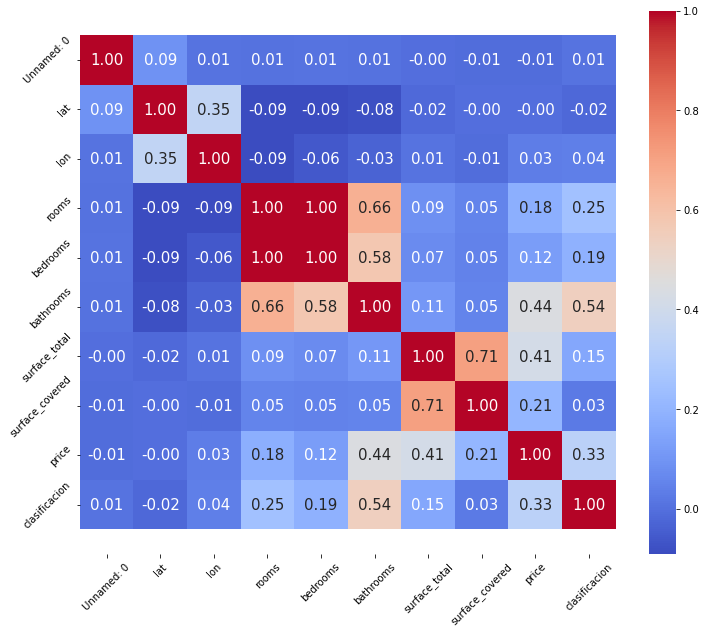

In [8]:
#se crea un gráfico de correlación entre las variables numéricas y el target (clasificación)

def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
corr = colombia_num.corr()
plot_corre_heatmap(corr)

In [9]:
#Se borran las columnas operation_type, ad_type y l1 ya que contienen una sola etiqueta por lo que la columna target no depende de estas.
colombiaTrain.drop(['operation_type', 'ad_type','l1'], axis = 1, inplace = True)

In [10]:
#Se borra la columna geometry porque otorga el mismo valor que las columnas lat y lon
colombiaTrain.drop(['geometry'], axis = 1, inplace = True)

In [11]:
#Se decide no trabajar con las columnas title y descripción, 
#ya que no se tienen los conocimientos suficientes para aplicar PLN de manera exitosa, 
#además esto complejizaría el modelo y se opta por uno más simple
colombiaTrain.drop(['title', 'description'], axis = 1, inplace = True)


In [12]:
#Se borra la columna created_on ya que contiene la misma información que start_date
colombiaTrain.drop(['created_on'], axis = 1, inplace = True)

In [13]:
#Se decide darle más importancia a la fecha en que se publicó el anuncio que a la fecha en la se vende,
#  por lo que se borra la fecha end_date
colombiaTrain.drop(['end_date'], axis = 1, inplace = True)

In [14]:
# La columna unnmed:0 y id, son justamente eso, id únicos para diferenciar cada aviso (fila), pero que no tienen incidencia con las casas, por lo que se decide eliminarlas
colombiaTrain.drop(['Unnamed: 0','id'], axis = 1, inplace = True)

In [15]:
#Se crea una nueva tabla por si llega a fallar algo y tener un df más avanzado y no empezar desde 0.
#Además se divide la columna start_date en año, meses y días
colombiaTrain2 = pd.concat([colombiaTrain.start_date.str.split('-',3, expand=True),colombiaTrain], axis = 1)

In [16]:
#Como se dividió la columna en start_date en año, mes y día, se procede a borrar la columna start_date
colombiaTrain2.drop(['start_date'], axis = 1, inplace = True)

In [17]:
#Se decide quedarse solamente de las columnas nuevas con el mes, 
# ya que año es el mismo (2020) y día también se quita porque el modelo de predicción quedaría demasiado complejo
colombiaTrain2.drop([0,2], axis = 1, inplace = True)

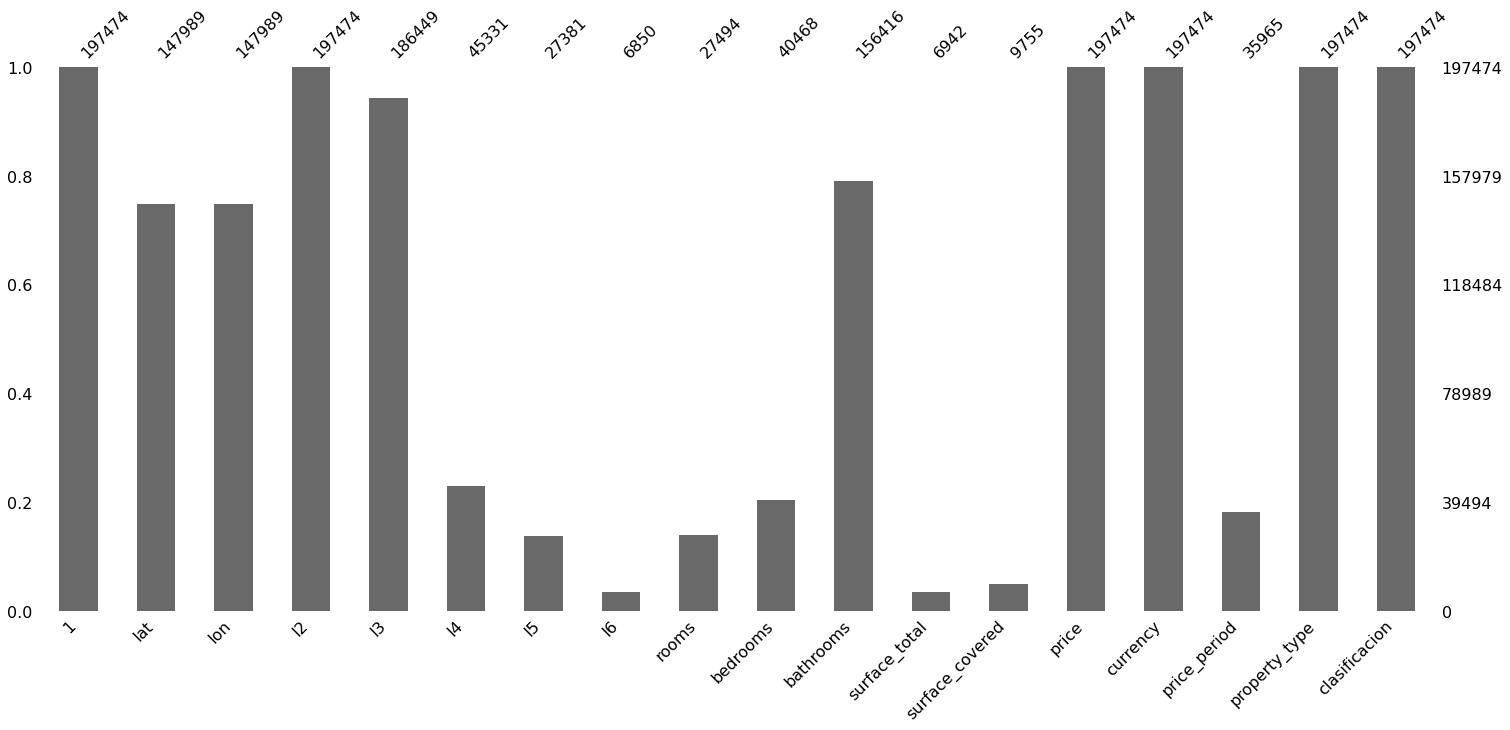

In [18]:
#Se hace un grafico para ver los valores nulos del dataset
import missingno as msno
msno.bar(colombiaTrain2)
plt.show()

In [19]:
#Se eliminan las columnas price_period, surface_covered, surface_total, bedrooms, rooms, l4,l5, l6, por falta de datos
colombiaTrain2 = colombiaTrain2.drop(['l4','l5','l6','rooms','bedrooms','surface_total','surface_covered','price_period'], axis = 1)

In [20]:
#Se elimina price ya que en el df colombiaTest, no se encuentra esta columna
colombiaTrain2.drop(['price'],axis = 1, inplace = True)

In [21]:
#Se resetean los índices
colombiaTrain2.reset_index(drop = True, inplace = True)

In [22]:
#Se toma la decisión de llenar con 0 los valores faltantes bathrooms ya que se suposo que si eran nulos era porque no tenían valor
colombiaTrain2.bathrooms = np.where(colombiaTrain2.bathrooms.isnull()==True, 0, colombiaTrain2.bathrooms)

In [23]:
#Se imputa valores faltantes a latitud y longitud a través de su moda
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(colombiaTrain2[['lat']])
colombiaTrain2['lat'] = imputer.transform(colombiaTrain2[['lat']])
imputer.fit(colombiaTrain2[['lon']])
colombiaTrain2['lon'] = imputer.transform(colombiaTrain2[['lon']])

In [24]:
#Se transforman las features categóricas a dummies
colombiaTrain2 = pd.get_dummies(colombiaTrain2, columns=['l2','l3', 'property_type','currency'])

In [25]:
#Se crea un df con las nuevas correlaciones
correlacionOH=colombiaTrain2.corr()

In [26]:
#Se visualiza solo aquellas columnas con más de 0.1 de correlación con respecto a clasificación
correlacion_positiva=correlacionOH[correlacionOH.clasificacion>0.1]
correlacion_positiva

,lat,lon,bathrooms,clasificacion,l2_Amazonas,l2_Antioquia,l2_Arauca,l2_Atlántico,l2_Bolívar,l2_Boyacá,...,l3_Zipaquirá,property_type_Apartamento,property_type_Casa,property_type_Finca,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_Parqueadero,currency_COP
bathrooms,-0.002524,-0.003029,1.000000,0.268121,-0.003864,-0.017394,0.001629,0.001129,-0.023718,-0.023354,...,-0.015533,-0.061112,0.300560,-0.069824,-0.072451,-0.377028,-0.057327,0.042080,-0.008918,NaN
clasificacion,-0.033683,0.045647,0.268121,1.000000,-0.005574,-0.009971,0.007072,-0.019005,0.017785,-0.002777,...,-0.013366,-0.257345,0.074242,0.076004,0.042010,0.109690,0.026481,0.191512,0.002774,NaN
l2_Cundinamarca,-0.285066,0.478349,0.011032,0.147807,-0.004977,-0.329183,-0.003691,-0.145946,-0.058934,-0.023210,...,0.097065,-0.022723,0.026045,-0.008011,0.033229,-0.025630,0.074953,-0.003978,-0.001729,NaN
l3_Bogotá D.C,-0.238976,0.406578,0.018578,0.129729,-0.004150,-0.274476,-0.003078,-0.121691,-0.049140,-0.019353,...,-0.019795,0.047379,-0.014839,-0.027124,0.028973,-0.078404,0.089628,-0.007243,-0.000915,NaN
property_type_Lote,-0.015081,-0.006003,-0.377028,0.109690,0.004235,0.010320,0.002650,-0.023988,-0.002808,0.044447,...,-0.002650,-0.307365,-0.200634,-0.022927,-0.024119,1.000000,-0.022391,-0.091249,-0.002149,NaN
property_type_Otro,-0.047986,-0.016672,0.042080,0.191512,-0.003041,-0.032215,0.009996,-0.030169,-0.022316,0.017840,...,-0.007252,-0.307619,-0.200800,-0.022946,-0.024139,-0.091249,-0.022410,1.000000,-0.002151,NaN


In [27]:
#Se visualiza solo aquellas columnas con menos -0.1 de correlación con respecto a clasificación
correlacion_negativa = correlacionOH[correlacionOH.clasificacion<-0.1]
correlacion_negativa

,lat,lon,bathrooms,clasificacion,l2_Amazonas,l2_Antioquia,l2_Arauca,l2_Atlántico,l2_Bolívar,l2_Boyacá,...,l3_Zipaquirá,property_type_Apartamento,property_type_Casa,property_type_Finca,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_Parqueadero,currency_COP
property_type_Apartamento,0.09767,-0.032994,-0.061112,-0.257345,0.000828,0.201415,-0.007598,-0.023045,0.039909,-0.028955,...,0.018605,1.0,-0.67638,-0.077292,-0.081311,-0.307365,-0.075486,-0.307619,-0.007244,NaN


In [28]:
#Se forma un df que con las features filtradas que contienen más correlación, las cuales servirán como labels para el modelo
XOH = pd.concat([colombiaTrain2.bathrooms,colombiaTrain2.l2_Cundinamarca,colombiaTrain2['l3_Bogotá D.C'],colombiaTrain2['property_type_Lote'],colombiaTrain2['property_type_Otro'],colombiaTrain2['property_type_Apartamento']],axis=1)

In [29]:
#se crea la variable target, la cual contiene los valores de la columna clasificación
y = colombiaTrain2.clasificacion

In [30]:
#Se separa entre valores de entrenamiento y valores de
from sklearn.model_selection import train_test_split


XOH_train, XOH_test, y_train, y_test = train_test_split(XOH, y, test_size=0.20, random_state=42)

print(XOH_train.shape, y_train.shape, XOH_test.shape, y_test.shape)

(157979, 6) (157979,) (39495, 6) (39495,)


In [31]:
#Se estandariza las features para ayudar al modelo
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
scXOH_train = scaler.fit_transform(XOH_train)
scXOH_test = scaler.fit_transform(XOH_test)

In [32]:
#Aplicamos regresión logística, ya que el target es binario (tiene solo 2 valores)

from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()

logReg.fit(scXOH_train,y_train)

LogisticRegression()

In [33]:
y_train_pred = logReg.predict(scXOH_train) # subset de entrenamiento
y_test_pred = logReg.predict(scXOH_test) #subset de testeo

In [36]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

print('El score del modelo es:', accuracy_score(y_train, y_train_pred))
print('El score del modelo es:', accuracy_score(y_test, y_test_pred))
print('El recall del modelo es:', recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

El score del modelo es: 0.7998721349040062
El score del modelo es: 0.7913153563742246
El recall del modelo es: 0.2508296756235949
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     30154
           1       0.65      0.25      0.36      9341

    accuracy                           0.79     39495
   macro avg       0.73      0.60      0.62     39495
weighted avg       0.77      0.79      0.75     39495



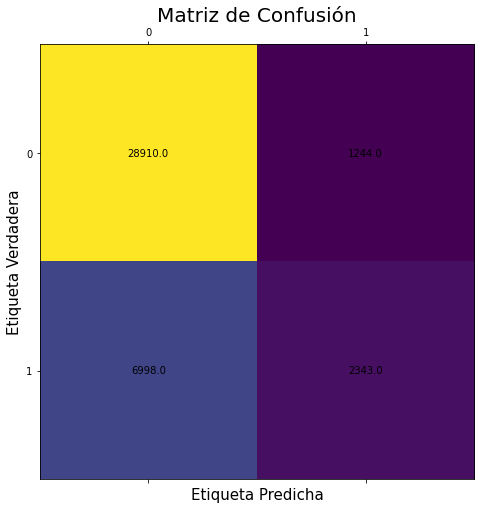

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Se verifica que el modelo no es bueno para predecir las casas que son caras, tan solo un 0.25 acierta por lo que se prosigue a elegir otros modelos

In [41]:
#Se opta por K-nearest Neighbor por ser un método sencillo y el cual sirve para clasificar nuevas muestras.
from sklearn.neighbors import KNeighborsClassifier
vecino = KNeighborsClassifier(n_neighbors=100) 
#Se decide trabajar con n_neighbors = 100 ya que se fue probando con distintos valores 
# y el que mejor rendimiento da, es justamente 100


In [45]:
XOH.head(1)

,bathrooms,l2_Cundinamarca,l3_Bogotá D.C,property_type_Lote,property_type_Otro,property_type_Apartamento
0,4.0,0,0,0,0,0


In [42]:
vecino.fit(scXOH_train, y_train)

KNeighborsClassifier(leaf_size=300, n_neighbors=100)

In [43]:
y_train_predk = vecino.predict(scXOH_train) # subset de entrenamiento
y_test_predk =vecino.predict(scXOH_test) #subset de testeo

In [44]:
print('El score del modelo es:', accuracy_score(y_train, y_train_predk))
print('El score del modelo es:', accuracy_score(y_test, y_test_predk))
print('El recall del modelo es:', recall_score(y_test, y_test_predk))
print(classification_report(y_test, y_test_predk))

El score del modelo es: 0.8188746605561499
El score del modelo es: 0.8162552221800228
El recall del modelo es: 0.34600149876886843
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     30154
           1       0.74      0.35      0.47      9341

    accuracy                           0.82     39495
   macro avg       0.78      0.65      0.68     39495
weighted avg       0.81      0.82      0.79     39495



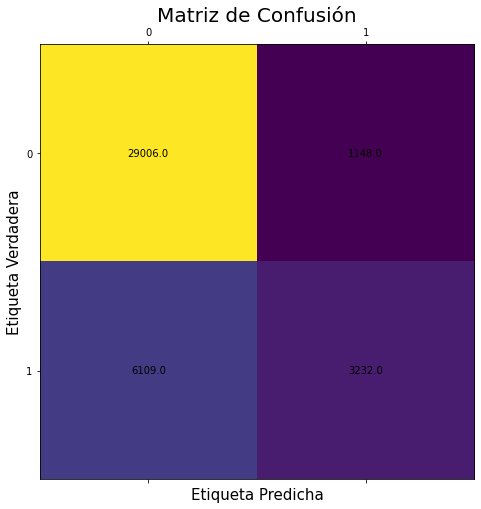

In [48]:
cm = confusion_matrix(y_test, y_test_predk)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

El modelo sigue sin ser bueno, pero se continua con otros 2 más para ver si se puede mejorar

In [49]:
#Se procede a unar un arbol de decisión
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

In [50]:
tree.fit(scXOH_train, y_train)

DecisionTreeClassifier(random_state=42)

In [51]:
# Se predice sobre nuestro set de entrenamiento

y_train_predtree = tree.predict(scXOH_train)

# Se predice sobre nuestro set de test

y_test_predtree = tree.predict(scXOH_test)

# Se comparacon las etiquetas reales
print('El score del modelo es:', accuracy_score(y_train, y_train_predtree))
print('El score del modelo es:', accuracy_score(y_test, y_test_predtree))
print('El recall del modelo es:', recall_score(y_test, y_test_predtree))
print(classification_report(y_test, y_test_predk))



El score del modelo es: 0.8212040840871255
El score del modelo es: 0.8214710722876314
El recall del modelo es: 0.4678299967883524
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     30154
           1       0.74      0.35      0.47      9341

    accuracy                           0.82     39495
   macro avg       0.78      0.65      0.68     39495
weighted avg       0.81      0.82      0.79     39495



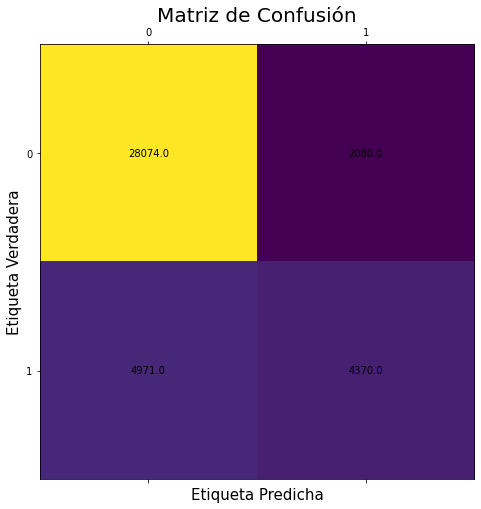

In [52]:
cm = confusion_matrix(y_test, y_test_predtree)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Da valores muy parecidos a knn

In [53]:
# se procede a usar un random forest
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
rfclf.fit(scXOH_train,y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [54]:
y_train_predrfclf = rfclf.predict(scXOH_train)
y_test_predrfclf = rfclf.predict(scXOH_test)


0.8212040840871255
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     30154
           1       0.68      0.47      0.55      9341

    accuracy                           0.82     39495
   macro avg       0.76      0.70      0.72     39495
weighted avg       0.81      0.82      0.81     39495



In [55]:
print('El score del modelo es:', accuracy_score(y_train, y_train_predrfclf))
print('El score del modelo es:', accuracy_score(y_test, y_test_predrfclf))
print('El recall del modelo es:', recall_score(y_test, y_test_predrfclf))
print(classification_report(y_test, y_test_predrfclf))

El score del modelo es: 0.8212040840871255
El score del modelo es: 0.8214710722876314
El recall del modelo es: 0.4678299967883524
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     30154
           1       0.68      0.47      0.55      9341

    accuracy                           0.82     39495
   macro avg       0.76      0.70      0.72     39495
weighted avg       0.81      0.82      0.81     39495



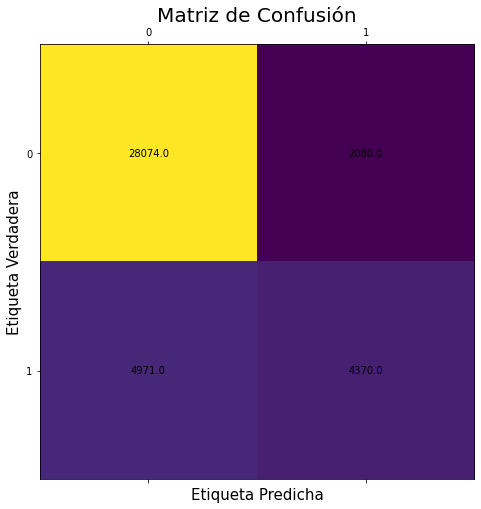

In [62]:
cm = confusion_matrix(y_test, y_test_predrfclf)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Si bien hay una mejora en el recall, no deja de ser mejor tirar una moneda al aire y elegir según como caiga si las casas que se saben que son caras clasificarlas entre baratas o caras 

Se llega a la conclusión de que las columnas son muy pocas para predecir de manera que correcta y se decide trabajar con todas las columnas del df "colombiaTrain2" y realizar una reducción de dimensión para ver si de esa forma se mejora el recall

In [57]:
df_pca = colombiaTrain2.drop(['clasificacion'], axis=1)
df_pca.shape

(197474, 337)

In [58]:
#Se procede a la reduccion de dimensiones con PCA, pero antes se estandariza. 
# Se elige que la cantidad de componentes sean los que demuestren el 88% de la varianza.
from sklearn.decomposition import PCA
sc_df_pca = scaler.fit_transform(df_pca)
pca = PCA(n_components = 0.88)
pca.fit(sc_df_pca)
reduced = pca.transform(sc_df_pca)

c:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [60]:
#Se ve que la nuevas cantidad de features se redujo de 337 a 267
pca.n_components_

267

In [61]:
pca_train, pca_test, y_train_pca, y_test_pca = train_test_split(reduced, y, test_size=0.20, random_state=42)

print(pca_train.shape, y_train_pca.shape, pca_test.shape, y_test_pca.shape)

(157979, 267) (157979,) (39495, 267) (39495,)


In [113]:
#Se vuelve a elegir randomforest porque fue el que mejor anduvo de lo anteriores
clf_pca = RandomForestClassifier(n_estimators=100,max_depth=10 ,max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)

In [114]:
clf_pca.fit(pca_train, y_train_pca)

RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, random_state=42)

In [118]:
y_train_pred_pca = clf_pca.predict(pca_train) # subset de entrenamiento
y_test_pred_pca =clf_pca.predict(pca_test) #subset de testeo

In [119]:
print('El score del modelo es:', accuracy_score(y_train, y_train_pred_pca))
print('El score del modelo es:', accuracy_score(y_test, y_test_pred_pca))
print('El recall del modelo es:', recall_score(y_test, y_test_pred_pca))
print(classification_report(y_test, y_test_pred_pca))

El score del modelo es: 0.8754391406452756
El score del modelo es: 0.8607165463982782
El recall del modelo es: 0.5999357670484958
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     30154
           1       0.76      0.60      0.67      9341

    accuracy                           0.86     39495
   macro avg       0.82      0.77      0.79     39495
weighted avg       0.85      0.86      0.85     39495



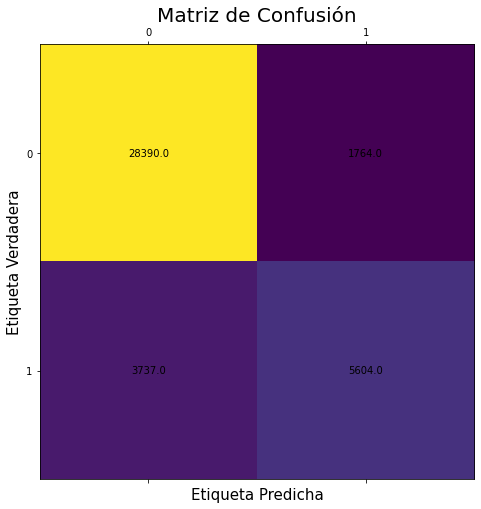

In [120]:
cm = confusion_matrix(y_test, y_test_pred_pca)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Si bien el recall mejoró considerablemente, no es lo suficientemente bueno como para predecir las casas caras

Se intenta llegar a un ajuste con y trabajar con menos fila, por lo que más que nada que probar, se utiliza label encoder en vez de get_dummies 

In [69]:
colombiaTrain.head(1)

,start_date,lat,lon,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,property_type,clasificacion
0,2020-12-14,6.203,-75.572,Antioquia,Medellín,El Poblado,NaN,NaN,NaN,4.0,4.0,NaN,NaN,9.000000e+09,COP,NaN,Casa,1


In [72]:
#Se procede a hacer los mismos pasos que con ColombiaTrain2
ColombiaLE = colombiaTrain
ColombiaLE = ColombiaLE.drop(['start_date','lat','lon','l4','l5','l6',
'rooms','bedrooms','surface_total','surface_covered','price','price_period','currency'], axis = 1)

In [73]:
ColombiaLE.head(1)

,l2,l3,bathrooms,property_type,clasificacion
0,Antioquia,Medellín,4.0,Casa,1


In [74]:
ColombiaLE.reset_index(drop = True, inplace = True)

In [75]:
# A diferencia de poner 0 en bathrooms en los valores nulos, ahora se decide que es mejor imputar el valor la moda
#para intentar tener mejor resultado
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(ColombiaLE[['bathrooms']])
ColombiaLE['bathrooms'] = imputer.transform(ColombiaLE[['bathrooms']])


In [76]:
#Se aplica label encoder para clasificar las etiquetas en base a números
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
  

ColombiaLE['l2'] = label_encoder.fit_transform(ColombiaLE['l2'])
ColombiaLE['property_type'] = label_encoder.fit_transform(ColombiaLE['property_type'])
ColombiaLE['l3'] = label_encoder.fit_transform(ColombiaLE['l3'])


In [77]:
#aplicamos correlación
ColombiaLE.corr()

,l2,l3,bathrooms,property_type,clasificacion
l2,1.000000,-0.180732,0.100424,0.061738,-0.011140
l3,-0.180732,1.000000,-0.067469,0.128971,-0.050978
bathrooms,0.100424,-0.067469,1.000000,0.054396,0.423728
property_type,0.061738,0.128971,0.054396,1.000000,0.272666
clasificacion,-0.011140,-0.050978,0.423728,0.272666,1.000000


In [78]:
#nos quedamos con las features que tienen más de 0.1 de correlacion
XLE = ColombiaLE.drop(['clasificacion','l3','l2'], axis = 1)

In [79]:
sc_XLE = scaler.fit_transform(XLE)

In [80]:
XLE_train, XLE_test, yLE_train, yLE_test = train_test_split(sc_XLE, y, test_size=0.20, random_state=42)

print(XLE_train.shape, yLE_train.shape, XLE_test.shape, yLE_test.shape)

(157979, 2) (157979,) (39495, 2) (39495,)


In [81]:
#Se vuelve a elegir vecinos más cercano ya que con random forest tuvimos overfitting
vecino_XLE = KNeighborsClassifier(n_neighbors=100, leaf_size= 300)

In [83]:
vecino_XLE.fit(XLE_train, yLE_train)

KNeighborsClassifier(leaf_size=300, n_neighbors=100)

In [84]:
y_train_pred_LE = vecino_XLE.predict(XLE_train) # subset de entrenamiento
y_test_pred_LE=vecino_XLE.predict(XLE_test) #subset de testeo

In [86]:
print('El score del modelo es:', accuracy_score(y_train, y_train_pred_LE))
print('El score del modelo es:', accuracy_score(y_test, y_test_pred_LE))
print('El recall del modelo es:', recall_score(y_test, y_test_pred_LE))
print(classification_report(y_test, y_test_pred_LE))

El score del modelo es: 0.8164882674279493
El score del modelo es: 0.8162299025193063
El recall del modelo es: 0.37148056953217
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     30154
           1       0.71      0.37      0.49      9341

    accuracy                           0.82     39495
   macro avg       0.77      0.66      0.69     39495
weighted avg       0.80      0.82      0.79     39495



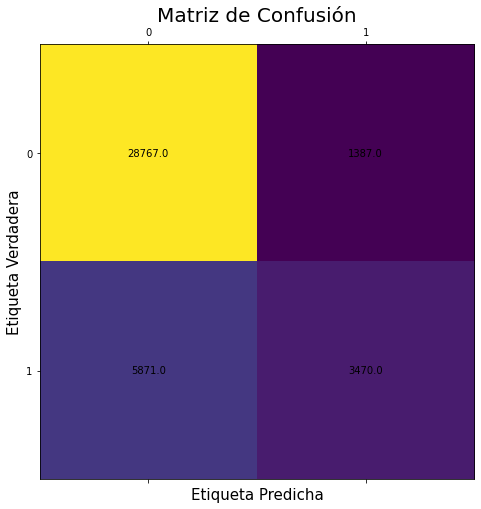

In [87]:
cm = confusion_matrix(yLE_test, y_test_pred_LE)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Se vuelve a empezar el EDA porque con las columnas trabajadas no se llega a un buen Recall para clasificar las casas caras.
Debido al EDA anterior en el cual ya habíamos visto que existe correlación entre las columnas rooms, bedrooms, surface_total, se dice rellenar los espacios vacíos con la medida de tendencia central mediana por sobre la media, ya que esta se ve más afectada por los valores atípicos.

In [88]:
#Se copia hace una copia del dataframe original para trabajar este nuevo EDA
colombiaRelleno = colombiaTrain.copy()

In [89]:
#Se reindexa el dataframe
colombiaRelleno.reset_index(drop = True, inplace = True)

In [90]:
#Se elige la medida de tendencia central mediana para completar los valores faltantes de la columna surface_total con respecto a la media ya que la columna tiene una gran varianza.
#Para dar un ejemplo de lo que hacen estas líneas va a usar de ejemplo la primera:
#Esta línea lo que hace es filtrar en la columna llamada "surface_total" todos los valores nulos que contengan en la columna "property_type" la etiqueta "Casa" y además que el target de clasificacion sea 0.
#A esta división de la columna se le otorga la mediana de la misma columna, tomando solo los valores que cumplan con la condición de que en la columna property_type, la etiqueta sea "Casa" y que en la columna clasificacion sea 0
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\965304331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_total[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\965304331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.surface_total[(colombiaRelleno.surface_total.isnull()==True)&(colombiaRelleno.prop

In [91]:
#Se repite los pasos anteriormente mencionados pero con la columna rooms
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.rooms[colombiaRelleno.property_type.isin(['Parqueadero'])] = 0 #para los parqueadores no había información sobre las habitaciones por lo que se intuye que al ser un garage no cuentan con estas y se otorga para todos el valor 0

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2103910891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.rooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2103910891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.rooms[(colombiaRelleno.rooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colom

In [92]:
#Se repite los pasos anteriormente mencionados pero con la columna bathrooms
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bathrooms[colombiaRelleno.property_type.isin(['Parqueadero'])] = 0 #siguiendo la lógica anterior, si no hay habitaciones contruidas no puede haber baños

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\724398645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bathrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\724398645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.bathrooms[(colombiaRelleno.bathrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Cas

In [93]:
#Se repite los pasos anteriormente mencionados pero con la columna bedrooms
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.bedrooms[colombiaRelleno.property_type.isin(['Parqueadero'])] = 0 #siguiendo la lógica anterior, si no hay habitaciones contruidas no puede haber habitaciones de dormir

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1929697955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.bedrooms[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1929697955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.bedrooms[(colombiaRelleno.bedrooms.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa']

In [690]:
'''#Se elige la medida de tendencia central mediana para completar los valores faltantes de la columna surface_total con respecto a la media ya que la columna tiene una gran varianza.

colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()'''

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_8036\1295855388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaRelleno.surface_covered[(colombiaRelleno.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_8036\1295855388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaRelleno.surface_covered[(colombiaRelleno.surface_covered.isnull()==True)&(colombia

In [94]:
#Se procede a crear solo un df con las columnas importantes y que tienen correlación con el target. A esto lo sabemos gracias al primer EDA realizado
Relleno = pd.concat([colombiaRelleno.rooms, colombiaRelleno.bedrooms,colombiaRelleno.bathrooms,colombiaRelleno.surface_total, colombiaRelleno.property_type, colombiaRelleno.clasificacion],axis=1)

In [95]:
#Se crean las columnas dummies a partir de la columna "property_type"
Relleno = pd.get_dummies(Relleno, columns=['property_type'])

In [96]:
#Se hace una correlación para ver que variables tienen más peso sobre el target.
Relleno.corr()

,rooms,bedrooms,bathrooms,surface_total,clasificacion,property_type_Apartamento,property_type_Casa,property_type_Finca,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_Parqueadero
rooms,1.000000,0.697852,0.396854,0.018922,0.413616,-0.257571,0.162928,0.098920,-0.066056,-0.269753,-0.106935,0.484473,-0.025919
bedrooms,0.697852,1.000000,0.411919,-0.189719,0.131604,0.036199,0.290007,0.082042,-0.157153,-0.659586,-0.141497,0.171795,-0.015672
bathrooms,0.396854,0.411919,1.000000,-0.004800,0.510273,-0.202711,0.308991,0.045634,-0.053283,-0.253523,-0.053020,0.122254,-0.013190
surface_total,0.018922,-0.189719,-0.004800,1.000000,0.214563,-0.189338,-0.056451,0.301392,-0.012059,0.373015,-0.013257,-0.012128,-0.000882
clasificacion,0.413616,0.131604,0.510273,0.214563,1.000000,-0.257345,0.074242,0.076004,0.042010,0.109690,0.026481,0.191512,0.002774
property_type_Apartamento,-0.257571,0.036199,-0.202711,-0.189338,-0.257345,1.000000,-0.676380,-0.077292,-0.081311,-0.307365,-0.075486,-0.307619,-0.007244
property_type_Casa,0.162928,0.290007,0.308991,-0.056451,0.074242,-0.676380,1.000000,-0.050453,-0.053076,-0.200634,-0.049274,-0.200800,-0.004729
property_type_Finca,0.098920,0.082042,0.045634,0.301392,0.076004,-0.077292,-0.050453,1.000000,-0.006065,-0.022927,-0.005631,-0.022946,-0.000540
property_type_Local comercial,-0.066056,-0.157153,-0.053283,-0.012059,0.042010,-0.081311,-0.053076,-0.006065,1.000000,-0.024119,-0.005923,-0.024139,-0.000568
property_type_Lote,-0.269753,-0.659586,-0.253523,0.373015,0.109690,-0.307365,-0.200634,-0.022927,-0.024119,1.000000,-0.022391,-0.091249,-0.002149


In [97]:
#Se dejan las variables que tienen una correlación menor a -0.1 y mayor a 0.1 ya que serán nuestras features para realizar el modelo
RellenoX = Relleno.drop(['property_type_Parqueadero','clasificacion','property_type_Casa','property_type_Finca','property_type_Local comercial','property_type_Oficina'], axis=1)

In [98]:
#Se dejan estandarizadas las features para ayudar al modelado
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
scX = scaler.fit_transform(RellenoX)

In [99]:
#Se dividen las features en la parte que se va a entrenar y en la cual se va a testear el modelo
scX_train, scX_test, yR_train, yR_test = train_test_split(scX, y, test_size=0.20, random_state=42)

print(scX_train.shape, yR_train.shape, scX_test.shape, yR_test.shape)

(157979, 7) (157979,) (39495, 7) (39495,)


In [100]:
#Se decide usar KNN ya que es el que mejor resultado dió en el primer EDA
vecinoR = KNeighborsClassifier(n_neighbors=100, leaf_size= 300)

In [101]:
#Se entrena el modelo
vecinoR.fit(scX_train, yR_train)

KNeighborsClassifier(leaf_size=300, n_neighbors=100)

In [102]:
#Se hacen las predicciones
y_train_pred_R = vecinoR.predict(scX_train) # subset de entrenamiento
y_test_pred_R=vecinoR.predict(scX_test) #subset de testeo

In [103]:
#Se mide que tal funciona el modelo
print('El score del modelo es:', accuracy_score(y_train, y_train_pred_R))
print('El score del modelo es:', accuracy_score(y_test, y_test_pred_R))
print('El recall del modelo es:', recall_score(y_test, y_test_pred_R))
print(classification_report(y_test, y_test_pred_R))

El score del modelo es: 0.9904987371739282
El score del modelo es: 0.99017597164198
El recall del modelo es: 0.977839631731078
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30154
           1       0.98      0.98      0.98      9341

    accuracy                           0.99     39495
   macro avg       0.99      0.99      0.99     39495
weighted avg       0.99      0.99      0.99     39495



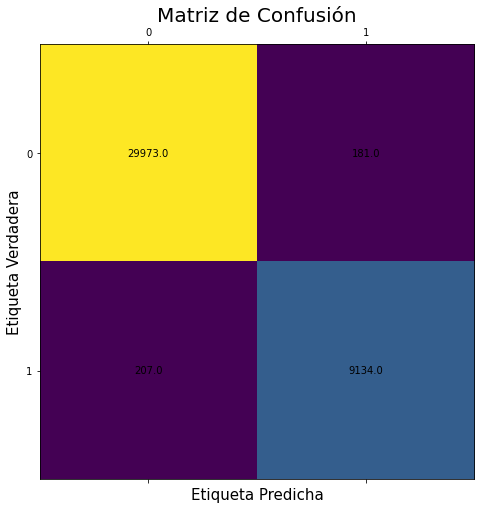

In [104]:
# Se dibuja la matriz de confusión
cm = confusion_matrix(yR_test, y_test_pred_R)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Se llega a un buen Recall y accuracy, aunque puede deberse a que este overfitteado el modelo. Vamos a usar el dataframe "ColombiaTest" y luego en el dashboard ver las métricas para saber que tal funciona.

In [111]:
colombiaTest=pd.concat([colombiaTest.rooms,colombiaTest.bedrooms,colombiaTest.bathrooms,colombiaTest.surface_total,colombiaTest.property_type],axis=1)

In [117]:
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\4176677472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.surface_total[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\4176677472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.surface_total[(colombiaTest.surface_total.isnull()==True)&(colombiaTest.property_type.isin(['Casa'

In [121]:
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\658190857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.rooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\658190857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.rooms[(colombiaTest.rooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion =

In [122]:
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1054705283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bedrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1054705283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.bedrooms[(colombiaTest.bedrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRellen

In [123]:
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Apartamento'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Otro'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Oficina'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Finca'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Lote'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 0)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Local comercial'])==True)&(colombiaRelleno.clasificacion == 1)].median()
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 0)]=0
colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Parqueadero'])==True)&(colombiaRelleno.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\4248547729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)]=colombiaTest.bathrooms[(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaRelleno.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\4248547729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest.bathrooms[(colombiaTest.bathrooms.isnull()==True)&(colombiaTest.property_type.isin(['Casa'])==True)&(colombiaR

In [126]:
colombiaTest= pd.get_dummies(colombiaTest, columns=['property_type'])

In [128]:
colombiaTestX = colombiaTest.drop(['property_type_Parqueadero','property_type_Casa','property_type_Finca','property_type_Local comercial','property_type_Oficina'], axis=1)

In [139]:
colombiaTestX.bedrooms.fillna(0, inplace = True)

In [140]:
colombiaTestX.rooms.fillna(0, inplace = True)

In [142]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
TestFinalX = scaler.fit_transform(colombiaTestX)

In [141]:
colombiaTestX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rooms                      65850 non-null  float64
 1   bedrooms                   65850 non-null  float64
 2   bathrooms                  65850 non-null  float64
 3   surface_total              65850 non-null  float64
 4   property_type_Apartamento  65850 non-null  uint8  
 5   property_type_Lote         65850 non-null  uint8  
 6   property_type_Otro         65850 non-null  uint8  
dtypes: float64(4), uint8(3)
memory usage: 2.2 MB


In [143]:
y_Final=vecinoR.predict(TestFinalX) #Sebas1412

In [144]:
y_Final

array([1, 0, 1, ..., 0, 0, 0])

In [145]:
d = {'pred': y_Final}
Seba1412=pd.DataFrame(data=d)

In [147]:
Seba1412.value_counts()

pred
0       58306
1        7544
dtype: int64

In [149]:
Seba1412.to_csv('Sebas1412.csv', index=False)

En efecto, el modelo esta overfitteado, por lo que da una pésima performance en el dashboard

Se decide usar RandomizedSearch para automatizar la busquedas de hiperparámetros para el modelo neighbors

In [152]:
import scipy as sp
from scipy import stats

param_dist = {'n_neighbors':range(2, 8),
              'weights': ['uniform', 'distance'], 
              'leaf_size':sp.stats.randint(1, 10),
              'algorithm':['auto', 'kd_tree']}

In [153]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier()
model = RandomizedSearchCV(knn, param_dist,n_iter=6, random_state=0, cv=5)

# Entrenamos knn con la grilla
model.fit(scX_train, yR_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=6,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019949D7BCD0>,
                                        'n_neighbors': range(2, 8),
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [154]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'algorithm': 'kd_tree', 'leaf_size': 3, 'n_neighbors': 6, 'weights': 'distance'}
Mejor Score: 0.9954361023060946



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.747483,0.142650,39.525241,2.792376,auto,6,2,distance,"{'algorithm': 'auto', 'leaf_size': 6, 'n_neigh...",0.995189,0.995158,0.995094,0.995031,0.995126,0.995120,0.000054,3
1,0.786516,0.287806,41.596986,3.993858,kd_tree,4,3,distance,"{'algorithm': 'kd_tree', 'leaf_size': 4, 'n_ne...",0.995411,0.995506,0.995063,0.994873,0.994968,0.995164,0.000250,2
2,0.844938,0.183382,64.415465,2.700483,kd_tree,3,6,distance,"{'algorithm': 'kd_tree', 'leaf_size': 3, 'n_ne...",0.995759,0.995379,0.995284,0.995316,0.995442,0.995436,0.000170,1
3,0.754461,0.250936,38.958831,4.328783,auto,9,2,uniform,"{'algorithm': 'auto', 'leaf_size': 9, 'n_neigh...",0.994715,0.994683,0.994430,0.994715,0.994619,0.994632,0.000107,6
4,1.196306,0.271651,60.613623,5.923686,auto,2,2,distance,"{'algorithm': 'auto', 'leaf_size': 2, 'n_neigh...",0.995189,0.995158,0.995094,0.995031,0.995126,0.995120,0.000054,3
5,0.853019,0.296660,35.428559,3.790833,kd_tree,9,3,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 9, 'n_ne...",0.995379,0.995284,0.995094,0.994588,0.994841,0.995037,0.000290,5


In [156]:
#Predecimos en los datos de test

prediction = model.predict(scX_test)


In [157]:
#Se mide que tal funciona el modelo

print('El score del modelo es:', accuracy_score(y_test, prediction))
print('El recall del modelo es:', recall_score(y_test, prediction))
print(classification_report(y_test, prediction))

El score del modelo es: 0.9957716166603368
El recall del modelo es: 0.9921849909003319
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30154
           1       0.99      0.99      0.99      9341

    accuracy                           1.00     39495
   macro avg       0.99      0.99      0.99     39495
weighted avg       1.00      1.00      1.00     39495



In [158]:
y_knn=model.predict(TestFinalX) #Sebas1412(1)

In [159]:
segundo = pd.DataFrame({'pred':y_knn})

In [160]:
segundo.value_counts()

pred
0       49743
1       16107
dtype: int64

In [164]:
segundo.to_csv('Sebas1412.csv', index=False)

Si bien ha mejorada la predicción de Recall en un 0.18, no alcanza a ser lo suficientemente bueno, además que se ve una baja del accuracy en 0.06

Se vuelve a probar k vecinos pero con otros hiperparámetros

In [165]:
param_dist2 = {'n_neighbors':range(6, 12),
              'weights': ['uniform', 'distance'], 
              'leaf_size':range(3, 8),
              'algorithm':['auto', 'kd_tree']}

In [172]:
from sklearn.model_selection import RandomizedSearchCV

knn2 = KNeighborsClassifier()
model2 = RandomizedSearchCV(knn2, param_dist2,n_iter=7, random_state=0, cv=5)

# Entrenamos knn con la grilla
model2.fit(scX_train, yR_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=7,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': range(3, 8),
                                        'n_neighbors': range(6, 12),
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [173]:
print("Mejores hiperparámetros: "+str(model2.best_params_))
print("Mejor Score: "+str(model2.best_score_)+'\n')

scores2 = pd.DataFrame(model2.cv_results_)
scores2

Mejores hiperparámetros: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Mejor Score: 0.9954930709416704



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_leaf_size,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.732384,0.119111,45.734231,2.690269,uniform,6,7,auto,"{'weights': 'uniform', 'n_neighbors': 6, 'leaf...",0.995379,0.995063,0.994936,0.994968,0.994619,0.994993,0.000244,4
1,0.695472,0.100545,42.014450,3.121819,uniform,11,5,kd_tree,"{'weights': 'uniform', 'n_neighbors': 11, 'lea...",0.994999,0.994430,0.994904,0.994651,0.994398,0.994677,0.000243,6
2,0.677911,0.034043,40.699409,3.291660,distance,11,5,kd_tree,"{'weights': 'distance', 'n_neighbors': 11, 'le...",0.995854,0.995411,0.995442,0.995411,0.995347,0.995493,0.000183,1
3,0.709964,0.024718,62.639510,2.361283,uniform,10,3,auto,"{'weights': 'uniform', 'n_neighbors': 10, 'lea...",0.995094,0.994398,0.995063,0.994746,0.994271,0.994714,0.000336,5
4,0.778921,0.254720,40.617176,3.505194,distance,6,6,kd_tree,"{'weights': 'distance', 'n_neighbors': 6, 'lea...",0.995759,0.995379,0.995284,0.995316,0.995442,0.995436,0.000170,2
5,0.871459,0.422124,42.804848,2.836368,uniform,11,4,auto,"{'weights': 'uniform', 'n_neighbors': 11, 'lea...",0.994999,0.994430,0.994904,0.994651,0.994398,0.994677,0.000243,6
6,1.004562,0.414258,58.091850,1.143872,distance,9,3,auto,"{'weights': 'distance', 'n_neighbors': 9, 'lea...",0.995696,0.995379,0.995379,0.995348,0.995379,0.995436,0.000130,3


In [174]:
#Predecimos en los datos de test

prediction2 = model2.predict(scX_test)

In [178]:
#Se mide que tal funciona el modelo

print('El score del modelo es:', accuracy_score(y_test, prediction2))
print('El recall del modelo es:', recall_score(y_test, prediction2))
print(classification_report(y_test, prediction2))

El score del modelo es: 0.9957462969996203
El recall del modelo es: 0.992399100738679
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30154
           1       0.99      0.99      0.99      9341

    accuracy                           1.00     39495
   macro avg       0.99      0.99      0.99     39495
weighted avg       1.00      1.00      1.00     39495



In [177]:
y_knn2=model2.predict(TestFinalX) #Sebas1412(2)

In [179]:
tercero = pd.DataFrame({'pred':y_knn2})

In [180]:
tercero.value_counts()

pred
0       53771
1       12079
dtype: int64

In [181]:
tercero.to_csv('Sebas1412.csv', index=False)

Tiene una performance peor que la anterior, parece que al aumentar el numero de vecinos, hace más complicado la performance del mismo con valores no conocidos.

Como se llega a la conclusión de que ya no se puede mejorar el modelo con knn, se empieza a probar con random forest classifier

In [182]:
modelclf = RandomForestClassifier(n_estimators=100,max_depth=10, random_state = 0)

In [183]:
modelclf.fit(scX_train, yR_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [184]:
predictionclf = modelclf.predict(scX_test)

In [185]:
print('El score del modelo es:', accuracy_score(y_test, predictionclf))
print('El recall del modelo es:', recall_score(y_test, predictionclf))
print(classification_report(y_test, predictionclf))

El score del modelo es: 0.9963033295353843
El recall del modelo es: 0.9934696499304143
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30154
           1       0.99      0.99      0.99      9341

    accuracy                           1.00     39495
   macro avg       0.99      1.00      0.99     39495
weighted avg       1.00      1.00      1.00     39495



In [186]:
y_clf=modelclf.predict(TestFinalX) #Sebas1412(3)

In [187]:
terceroclf = pd.DataFrame({'pred':y_clf})
terceroclf.value_counts()

In [189]:
terceroclf.to_csv('Sebas1412.csv', index=False)

Se comprueba que hay un aumento considerable en los score aunque sigue siendo pobre el modelo, pero se ve que random classifier se adapta mejor que vecinos más cercanos

Teniendo en cuenta el resultado anterior, se prueba un randomizedSearch para ver si se encuentra una mejor performance

In [191]:
colombiaTestX.to_csv('colombiaNorm.csv', index = False)

In [204]:
param_dist3 = {'n_estimators':sp.stats.randint(1,101),
              'max_depth': sp.stats.randint(2,25), 
              'n_jobs':[-1],
              'random_state':[0],
              'criterion' :["gini", "entropy", "log_loss"]
              }

In [205]:
clf2 = RandomForestClassifier()
model4 = RandomizedSearchCV(clf2, param_dist3,n_iter=100, random_state=0, cv=5)

# Entrenamos knn con la grilla
model4.fit(scX_train, yR_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019958F43D60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019958F8E8F0>,
                                        'n_jobs': [-1], 'random_state': [0]},
                   random_state=0)

In [206]:
print("Mejores hiperparámetros: "+str(model4.best_params_))
print("Mejor Score: "+str(model4.best_score_)+'\n')

scores4 = pd.DataFrame(model4.cv_results_)
scores4

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 85, 'n_jobs': -1, 'random_state': 0}
Mejor Score: 0.9961577162427346



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.113188,4.326442,0.148432,0.020099,gini,17,65,-1,0,"{'criterion': 'gini', 'max_depth': 17, 'n_esti...",0.995949,0.995981,0.995854,0.995442,0.995790,0.995803,0.000193,31
1,1.295043,0.043992,0.052732,0.002880,entropy,21,22,-1,0,"{'criterion': 'entropy', 'max_depth': 21, 'n_e...",0.996012,0.995886,0.995696,0.995379,0.995664,0.995727,0.000216,48
2,3.686666,0.144124,0.161968,0.012119,log_loss,6,88,-1,0,"{'criterion': 'log_loss', 'max_depth': 6, 'n_e...",0.994018,0.994493,0.994176,0.993512,0.994113,0.994063,0.000318,70
3,3.235635,0.063837,0.124367,0.002423,log_loss,14,59,-1,0,"{'criterion': 'log_loss', 'max_depth': 14, 'n_...",0.996012,0.996234,0.996075,0.995601,0.995664,0.995917,0.000244,23
4,1.997682,0.048705,0.083161,0.002921,entropy,8,40,-1,0,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",0.996012,0.995917,0.996107,0.995221,0.996329,0.995917,0.000374,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.966703,0.173978,0.096759,0.008216,entropy,14,45,-1,0,"{'criterion': 'entropy', 'max_depth': 14, 'n_e...",0.995949,0.996234,0.996012,0.995664,0.995664,0.995905,0.000218,25
96,2.395401,0.021499,0.133246,0.010734,entropy,4,92,-1,0,"{'criterion': 'entropy', 'max_depth': 4, 'n_es...",0.992183,0.992467,0.992436,0.991803,0.992594,0.992296,0.000281,90
97,1.495966,0.045833,0.081253,0.010298,entropy,9,40,-1,0,"{'criterion': 'entropy', 'max_depth': 9, 'n_es...",0.996139,0.995949,0.995727,0.995506,0.996360,0.995936,0.000300,19
98,2.814827,0.085555,0.139407,0.009757,log_loss,19,71,-1,0,"{'criterion': 'log_loss', 'max_depth': 19, 'n_...",0.995949,0.995981,0.995632,0.995348,0.995664,0.995715,0.000232,52


In [207]:
prediction4 = model4.predict(scX_test)
print('El score del modelo es:', accuracy_score(y_test, prediction4))
print('El recall del modelo es:', recall_score(y_test, prediction4))
print(classification_report(y_test, prediction4))

El score del modelo es: 0.9963033295353843
El recall del modelo es: 0.9928273204153731
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30154
           1       0.99      0.99      0.99      9341

    accuracy                           1.00     39495
   macro avg       0.99      1.00      0.99     39495
weighted avg       1.00      1.00      1.00     39495



In [208]:
y_model4=model4.predict(TestFinalX) #Sebas1412(4 y 5)

In [209]:
cuarto = pd.DataFrame({'pred':y_model4})
cuarto.value_counts()


pred
0       46066
1       19784
dtype: int64

In [210]:
cuarto.to_csv('Sebas1412.csv', index=False)

Hay una pequeña mejora pero nada que haga cambiar la verdad. Aunque probemos todos los modelos de la librería sckelearn esto no va a mejorar. Por lo que están mal rellenados los datos de dataframe Test o lo que es más probable: que el EDA que hemos hecho no sea el adecuado y haya que empezar de 0.

Como decisión de último momento y para tratar de que la empresa inversora tenga buena información, se decide cambiar la forma de imputar los valores faltantes. Esta vez en vez de usar las diferentes medianas del dataframe Test, se uso la mediana del dataframe Train.

In [258]:
colombiaTest1 = pd.read_csv('properties_colombia_test.csv')

In [259]:
colombiaTest1=pd.concat([colombiaTest1.rooms,colombiaTest1.bedrooms,colombiaTest1.bathrooms,colombiaTest1.surface_total,colombiaTest1.property_type],axis=1)

In [260]:
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 0)]=0
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\3737770539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\3737770539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['C

In [282]:
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Apartamento'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Lote']))]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Lote'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial']))]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Local comercial'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2608758895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.surface_total[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2608758895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.surface_total[(colombiaTest1.surface_total.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.surface_total[(colombiaTrain.property_ty

In [262]:
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 0)]=0
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2899295972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2899295972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificaci

In [283]:
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote']))]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Lote'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial']))]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1999459848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1999459848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.rooms[(colombiaTest1.rooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.rooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)].median()
C:\Use

In [264]:
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 0)]=0
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1471497335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1471497335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTr

In [284]:
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote']))]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Lote'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial']))]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2093260190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\2093260190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bedrooms[(colombiaTest1.bedrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.bedrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True

In [266]:
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Otro'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Oficina'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Finca'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Lote'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 0)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)&(colombiaTrain.clasificacion == 1)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 0)]=0
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Parqueadero'])==True)&(colombiaTrain.clasificacion == 1)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1846629563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)&(colombiaTrain.clasificacion == 0)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1846629563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)&(colom

In [285]:
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Apartamento'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Lote']))]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Lote'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Local comercial']))]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Local comercial'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Otro'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Finca'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Parqueadero'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Oficina'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()

C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1347116462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Casa'])==True)]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Casa'])==True)].median()
C:\Users\Nueva era\AppData\Local\Temp\ipykernel_1460\1347116462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombiaTest1.bathrooms[(colombiaTest1.bathrooms.isnull()==True)&(colombiaTest1.property_type.isin(['Apartamento']))]=colombiaTrain.bathrooms[(colombiaTrain.property_type.isin(['Apartamento'])

In [287]:
colombiaTest1= pd.get_dummies(colombiaTest1, columns=['property_type'])

In [288]:
colombiaTest1X = colombiaTest1.drop(['property_type_Parqueadero','property_type_Casa','property_type_Finca','property_type_Local comercial','property_type_Oficina'], axis=1)

In [293]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
TestFinal1X = scaler.fit_transform(colombiaTest1X)

In [294]:
y_model4_reload=model4.predict(TestFinal1X) #Sebas1412(6)

In [296]:
quinto = pd.DataFrame({'pred':y_model4_reload}) 
quinto.value_counts()

pred
1       44938
0       20912
dtype: int64

In [297]:
quinto.to_csv('Sebas1412.csv', index=False)

Lamentablemente no se pudo llegar a buenos resultados, no predice de manera acertada los datos que no conoce. Se llama a la empresa y se le dice que después de varios intentos, no se puede cumplir con lo esperado y se le pide más tiempo para realizar un EDA de mayor calidad.